# Description

This notebook explores the effect of "overfitting" data splitting on subsequent treatment effect estimates.

# Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sys

from ipywidgets import interact_manual
from scipy.stats import norm
from scipy.special import logit
from sklearn.base import clone
from linearmodels.iv import IV2SLS

# user imports
sys.path.append("../")

from utils.pwr import rdd_power, iv_power

In [2]:
# matplotlib config
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 300

In [3]:
#Import necessary packages
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
#Must be activated
pandas2ri.activate()

# Generate single-run data

In [4]:
n = 1000
seed = 42
prop_comply = 0.5
tau = 0.2

np.random.seed(seed)

Z_T = 0.5
C_T = 0.5

# vars:             Z    T    C
covar = np.array([[1.0, Z_T, 0.0], # Z
                  [Z_T, 1.0, C_T], # T
                  [0.0, C_T, 1.0]])# C
#covar += np.eye(3,3)

# vars:  Z  T  C
means = [0, 0, 0]

# generate some data
data = np.random.multivariate_normal(mean=means, cov=covar, size=n)

print(data.shape)
# generate random instrument
#Z = np.random.randint(0,2,n)
Z = (data[:, 0] > 0).astype(int)

# generate random binary covariate for compliance
X = np.random.random_sample(n)
X = (X < prop_comply).astype(int)

# generate endogenous treatment
T = (data[:, 1] > 0).astype(int)

# first fill with random values
#T = np.random.randint(0,2,n)

# fill in Z when the sample is a complier
T = np.where(X == 1, Z, T)

# generate a confounder: correlation with treatment
#C = np.random.normal(0.5*T, 0.5)
C = data[:, 2]

Y = tau*T + C + np.random.normal(0, 1, 1000)

(1000, 3)


In [5]:
df = pd.DataFrame()
df['Z'] = Z
df['X'] = X
df['T'] = T
df['C'] = C
df['Y'] = Y

In [6]:
df.corr()

,Z,X,T,C,Y
Z,1.000000,-0.029419,0.683685,-0.042523,0.035377
X,-0.029419,1.000000,-0.004928,0.037883,0.030164
T,0.683685,-0.004928,1.000000,0.158523,0.172074
C,-0.042523,0.037883,0.158523,1.000000,0.726163
Y,0.035377,0.030164,0.172074,0.726163,1.000000


In [7]:
formula = 'Y ~ 1 + [T ~ Z]'

In [8]:
iv_model = IV2SLS.from_formula(formula, df)
iv_results = iv_model.fit(cov_type='robust')

In [9]:
display(iv_results)
var = iv_results.std_errors['T']**2
pwr = rdd_power(tau, var)
print(pwr)
print(iv_power(df, tau))


IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                      0.0151
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0141
No. Observations:                1000   F-statistic:                    1.2730
Date:                Tue, Sep 28 2021   P-value (F-stat)                0.2592
Time:                        09:06:23   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.0545     0.0780    -0.6993     0.4844     -0.2073      0.0983
T              0.1487     0.1318     1.1283     0.2592     -0.1096      0.4070
==============================================================================

Endogenous: T
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7fcfd1e317d0

0.3293345284537802
0.32884887510612126


# Simulation data functions

In [111]:
# def generate_IV(n, tau, prop_comply, seed):
#     np.random.seed(seed)

#     # generate random instrument
#     Z = np.random.randint(0,2,n)

#     # generate random binary covariate for compliance
#     X = np.random.random_sample(n)
#     X = (X < prop_comply).astype(int)

#     # generate endogenous treatment
#     # first fill with random values
#     T = np.random.randint(0,2,n)

#     # fill in Z when the sample is a complier
#     T = np.where(X == 1, Z, T)

#     # generate a confounder: correlation with treatment
#     C = np.random.normal(0.5*T, 0.5)

#     Y = tau*T + C + np.random.normal(0, 1, n)
    
#     df = pd.DataFrame()
#     df['Z'] = Z
#     df['X'] = X
#     df['T'] = T
#     df['C'] = C
#     df['Y'] = Y
    
#     return df

In [655]:
# alternative formulation with shared covariance
def generate_IV(n, tau, prop_comply, seed, C_T=0.8, prop_nt=0.5, prop_z=0.5):
    """
    Generates IV data with compliance indicator X.
    
    Args:
        prop_comply (float): the *total proportion* of compliers in the data
        C_T (float): the confounding strength between C and T
            TODO needs to be fixed, by generating shared covariance for compliers and noncompliers
        prop_nt (float): the proportion of never takers *among non-compliers*
        
    
    """
    np.random.seed(seed)

    Z_T = 0.8

    # vars:             Z    T    C
    covar = np.array([[1.0, Z_T, 0.0], # Z
                      [Z_T, 1.0, C_T], # T
                      [0.0, C_T, 1.0]])# C
    
    covar += np.eye(3,3)

    # vars:  Z  T  C
    means = [0, 0, 0]

    # generate some data
    data = np.random.multivariate_normal(mean=means, cov=covar, size=n)

    # generate binary instrument
    Z = (data[:, 0] > norm.ppf(1-prop_z)).astype(int)

    # generate random binary covariate for compliance
    X = np.random.random_sample(n)
    X = (X < prop_comply).astype(int)

    # generate endogenous treatment
    T = (data[:, 1] > 0).astype(int)

    # fill in Z when the sample is a complier
    T = np.where(X == 1, Z, T)
    
    # set never takers to prop_nt of non-compliers
    T[X != 1] = (np.random.sample((X != 1).sum()) > prop_nt).astype(int)

    # generate a confounder: correlation with treatment
    # problem with this approach, creates a path T -> C -> Y
    #     C = np.random.normal(loc=C_T * (T - np.mean(T)), 
    #                          scale=1 - (C_T**2))
    C = data[:, 2]
    
    # add noncomplier bias
    nc_bias_eff = 0.25
    B = np.where(X != 1, nc_bias_eff, 0)

    Y = (tau + B)*T + C + np.random.normal(0, 1, n)
    
    df = pd.DataFrame()
    df['Z'] = Z
    df['X'] = X
    df['T'] = T
    df['C'] = C
    df['Y'] = Y
    df['B'] = B
    
    return df

In [656]:
formula = 'Y ~ 1 + [T ~ Z]'

def simulation(n, tau, prop_comply, n_trials, exclude_criteria=None, confound_str=0.8):
    pwrs = []
    tau_hats = []
    n_excluded = []
    var_hats = []
    
    for trial in range(n_trials):
        df = generate_IV(n, tau, prop_comply, trial, confound_str)
        
        if exclude_criteria == "TneqZ":
            sel_df = df[df['T'] == df['Z']]
        elif exclude_criteria == "comply":
            sel_df = df[df['X'] == 1]
        elif exclude_criteria is None:
            sel_df = df
            
        iv_model = IV2SLS.from_formula(formula, sel_df)
        iv_results = iv_model.fit(cov_type='robust')
        var = iv_results.std_errors['T']**2
        tau_hat = iv_results.params['T']
        
        pwr = rdd_power(tau, var)
        pwrs.append(pwr)
        tau_hats.append(tau_hat)
        var_hats.append(var)
        
        n_excluded.append(df.shape[0] - sel_df.shape[0])

    return tau_hats, pwrs, var_hats, n_excluded

In [657]:
def plot_results(tau, tau_hats, pwrs, var_hats, n_exclude):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), dpi=150)
    sns.boxplot(data=tau_hats, ax=ax1, orient='h')
    ax1.axvline(tau, color='black', ls='--', label="true treatment effect", )
    ax1.set_xlim(tau - 1.5, tau + 1.5)
    ax1.legend()
    ax1.set_ylabel("Est. treatment effect")

    sns.boxplot(data=pwrs, color='green', ax=ax2, orient='h')
    ax2.set_xlim(0, 1)
    ax2.set_ylabel("Est. power")
    
    
    sns.boxplot(data=var_hats, color='red', ax=ax3, orient='h')
    ax3.set_xlim(0, 0.5)
    ax3.set_ylabel("Std. errors")

    
    sns.boxplot(data=n_exclude, color='orange', ax=ax4, orient='h')
    #ax2.set_xlim(0, 1)
    ax4.set_ylabel("Num excluded")

## Simulation sandbox

In [626]:
n = 500
n_trials = 500
prop_comply = 0.5
tau = 0.5

In [627]:
seed = 42
test_df = generate_IV(n, tau, prop_comply, seed, C_T=0.8)
display(test_df.head())

,Z,X,T,C,Y,B
0,0,1,0,6.033e-04,-1.525,0.00
1,0,0,0,-1.223e+00,-2.356,0.25
2,0,1,0,-2.383e+00,-2.602,0.00
3,0,1,0,-2.337e-01,-2.872,0.00
4,0,1,0,8.954e-01,1.674,0.00


0.6330237852563544
CPU times: user 1min 37s, sys: 2.75 s, total: 1min 40s
Wall time: 12.6 s


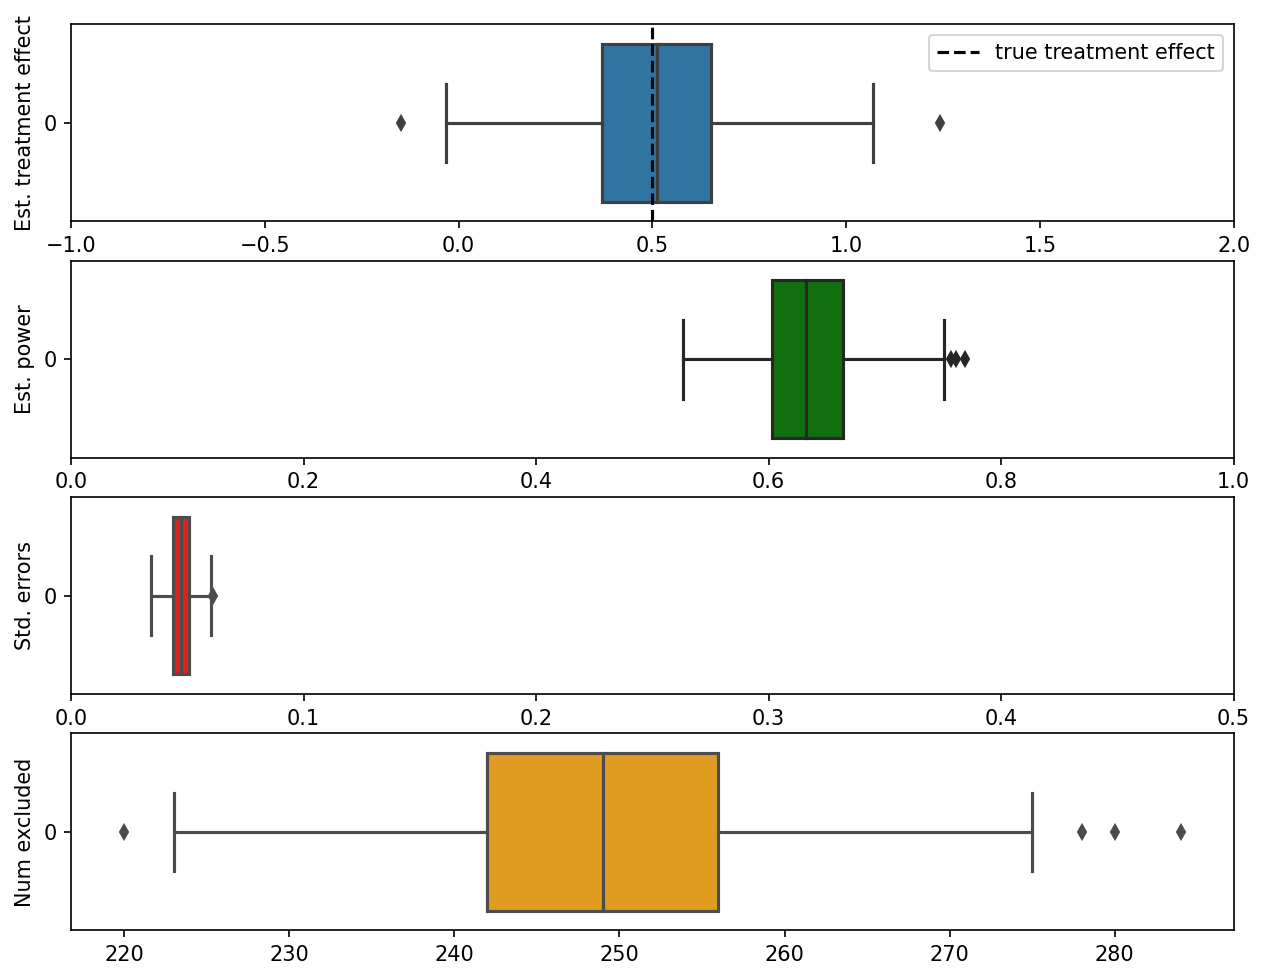

In [628]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, "comply")

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

0.7530720831977483
CPU times: user 1min 8s, sys: 1.81 s, total: 1min 10s
Wall time: 8.78 s


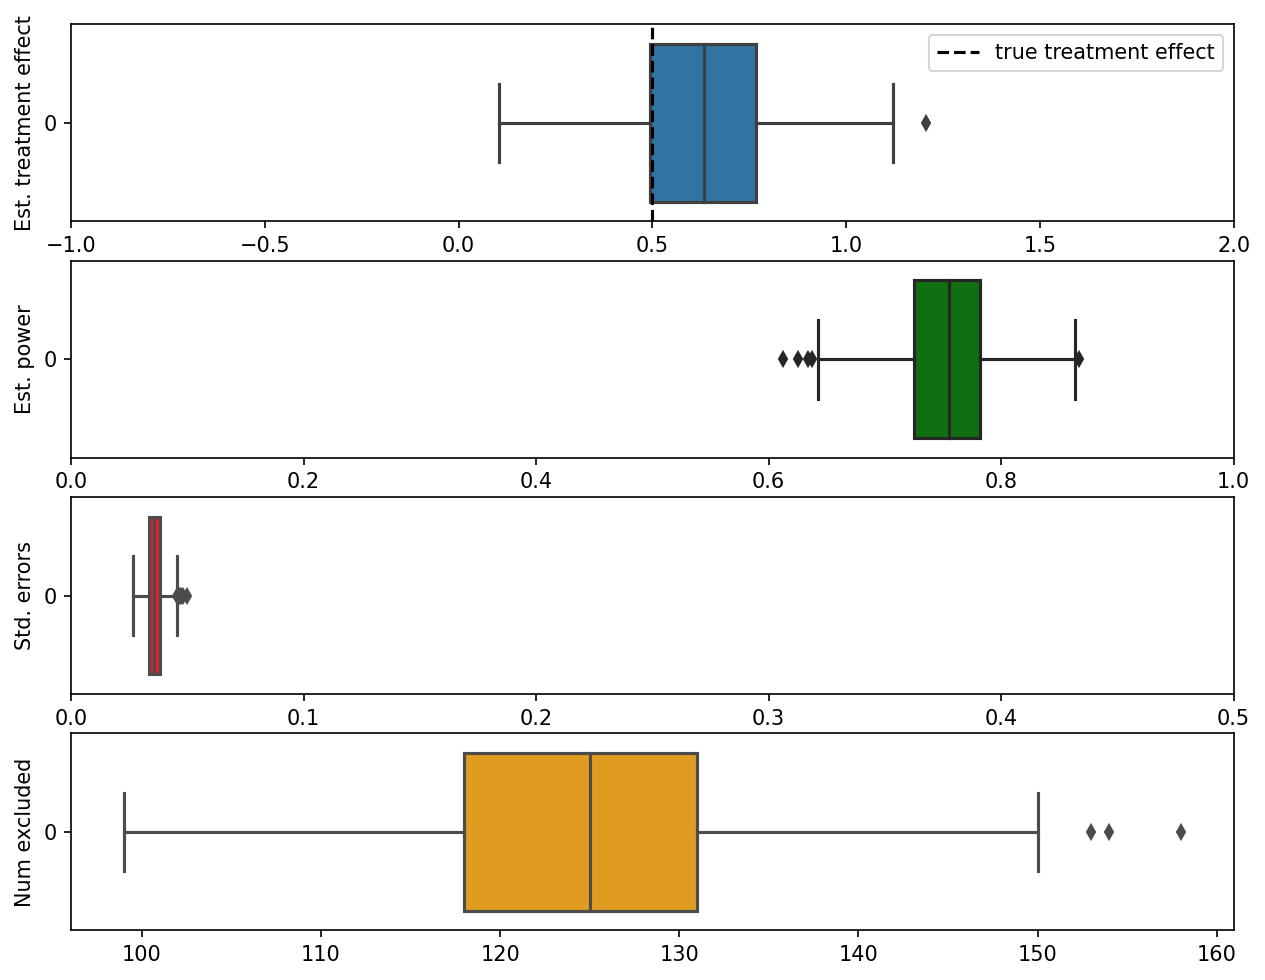

In [413]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, "TneqZ")

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

0.36749602484437116
CPU times: user 1min 4s, sys: 1.77 s, total: 1min 6s
Wall time: 8.29 s


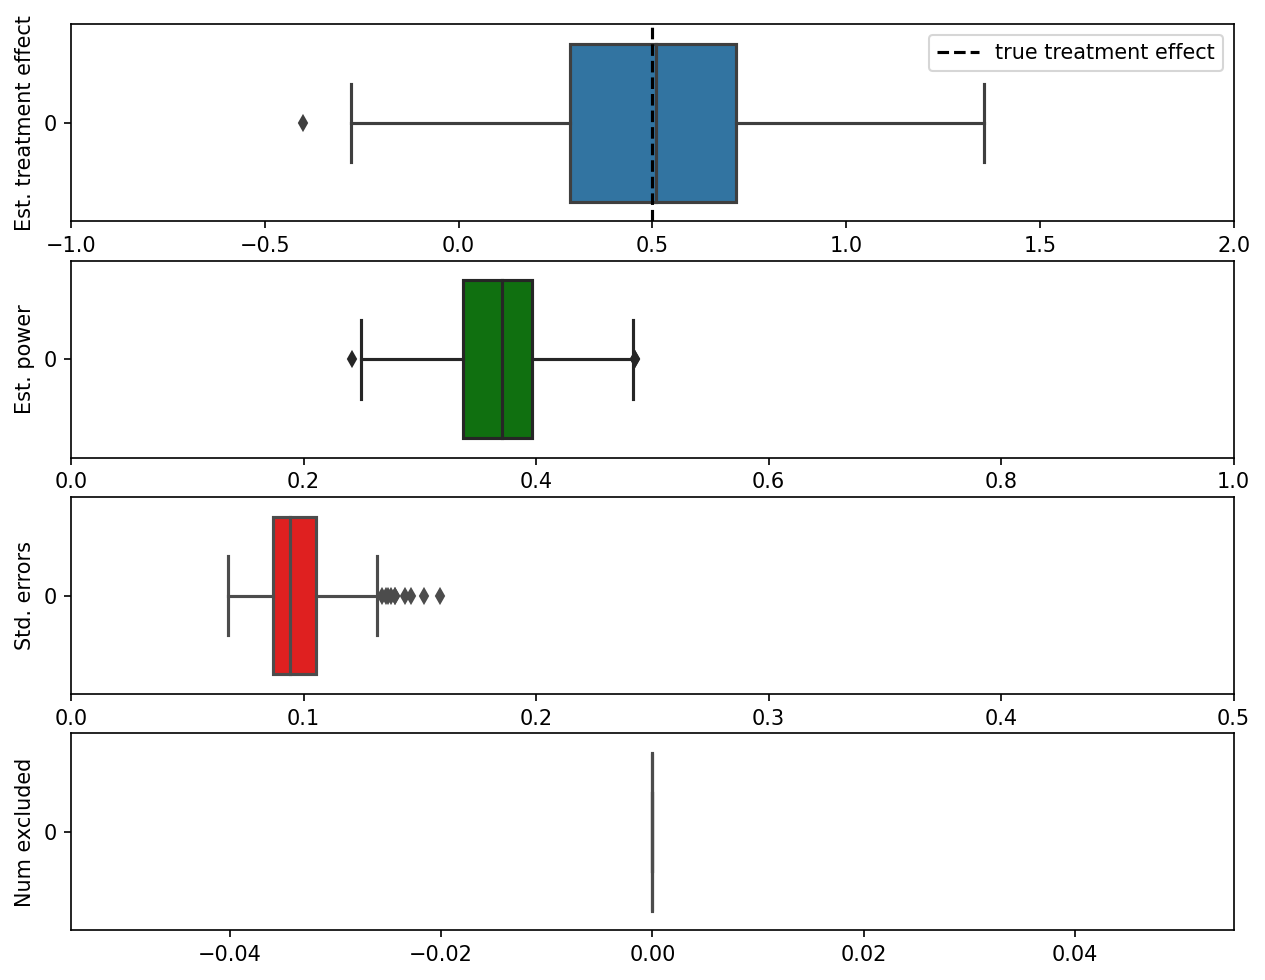

In [414]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, None)

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

## Widget

In [415]:
pd.set_option("display.precision", 3)

In [416]:
import warnings
warnings.filterwarnings('ignore')

@interact_manual(
    excl_type = [
        ("No exclusion", None),
        ("Per-protocol: T neq Z", "TneqZ"),
        ("True noncompliers", "comply")
    ],
    n=(100,1000,50),
    n_trials=(100,1000,50),
    prop_comply=(0,1, 0.1),
    tau=(-1, 1, 0.1),
    confound_str=(0, 1, 0.1)
)
def sim_plot_iv_exclusion(excl_type, n=500, n_trials=500, prop_comply=0.5, tau=0.5, confound_str=0.8):
    tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, excl_type, confound_str)
    df = pd.DataFrame()
    df['tau_hat'] = tau_hats
    df['var_hat'] = var_hats
    df['power'] = pwrs
    df['n_exclude'] = n_exclude
    plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
    display(df.describe().transpose())

interactive(children=(Dropdown(description='excl_type', options=(('No exclusion', None), ('Per-protocol: T neq…

**TODO** figure out why excluding the observed noncompliers *isn't* biasing estimates
- answer: "per-protocol" analyses (where we only analyze observed compliers) is generally biased, but only when there are confounders (see Chapter 23.9.2 of Imbens & Rubin)
- Next thing to figure out: why is the power increase minimal even in the presence of a perfect compliance indicator?

# ML sandbox

## Linear model of likely compliance

In [658]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [659]:
n = 2000
tau = 0.5
prop_comply = 0.4
prop_nt = 0.8
prop_z = 0.8
seed = 42
data = generate_IV(n, tau, prop_comply, seed, C_T=0.8, prop_nt=prop_nt, prop_z=prop_z)
display(data.head())

,Z,X,T,C,Y,B
0,1,1,1,6.033e-04,-1.244,0.00
1,0,1,0,-1.223e+00,-2.278,0.00
2,0,1,0,-2.383e+00,-2.707,0.00
3,0,1,0,-2.337e-01,-0.022,0.00
4,0,0,0,8.954e-01,1.906,0.25


In [660]:
data['comply_indicator'] = data['T'] == data['Z'] 

In [661]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

for train_idx, test_idx in kfold.split(data, y=data['comply_indicator']):
    indices.append(test_idx)
    

s1_df = data.iloc[indices[0]].copy()
s2_df = data.iloc[indices[1]].copy()


In [662]:
lr_model = LogisticRegression()
lr_model.fit(s1_df[['X']], s1_df['comply_indicator'])
print(lr_model.score(s1_df[['X']], s1_df['comply_indicator']))
print(lr_model.score(s2_df[['X']], s2_df['comply_indicator']))

0.798
0.767


In [663]:
s1_df[s1_df['X'] == 0]['comply_indicator'].value_counts()

False    376
True     202
Name: comply_indicator, dtype: int64

In [664]:
lr_preds = lr_model.predict_proba(s2_df[['X']])[:, 1]

- likely compliance prediction will predict p(likely compliance) == 1 for X=1, then E(likely compliance | X = 0) 

## Causal forest on heterogeneous instrument effects

In [665]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, r

In [666]:
pandas2ri.activate()
r_grf = importr('grf')
r_utils = importr('utils')

In [667]:
r_forest = r_grf.causal_forest(
    # grf expects a matrix for X, vectors for W, Y
    X = s1_df[['X']],
    W = s1_df['Z'],
    Y = s1_df['T'],
)

In [668]:
# predicted heterogeneous instrument effects
comp_hat = r.predict(r_forest, s2_df[['X']])

In [669]:
comp_hat.columns = ['cf_preds']
comp_hat['lr_preds'] = lr_preds

In [670]:
comp_hat

,cf_preds,lr_preds
1,1.000,0.988
2,1.000,0.988
3,1.000,0.988
4,-0.031,0.358
5,-0.031,0.358
...,...,...
996,1.000,0.988
997,1.000,0.988
998,-0.031,0.358
999,-0.031,0.358


- p_nt = 0.12
- p_at = 0.48
- p_co = 0.4

In [671]:
data[(data['Z'] == 0) & (data['X'] == 0)]['T'].mean()

0.19393939393939394

In [672]:
data[(data['Z'] == 1) & (data['X'] == 0)]['T'].mean()

0.19696969696969696

In [673]:
test = data[data['X'] == 0]
test = test[test['Z'] == 1]
(test['Z'] == test['T']).sum()

169

In [674]:
p_at = data[(data['Z'] == 0) & (data['T'] == 1)].shape[0] / data[data['Z'] == 0].shape[0]
p_at

0.11130434782608696

In [676]:
p_nt = data[(data['Z'] == 1) & (data['T'] == 0)].shape[0] / data[data['Z'] == 1].shape[0]
p_nt

0.48350877192982455

In [677]:
1 - p_at - p_nt

0.40518688024408844

In [678]:
data[data['X'] == 1]['T'].mean()

0.6982758620689655

In [679]:
test = data[data['X'] == 1]

(test['Z'] == 1).sum()

567

In [682]:
(p_nt + prop_z*(p_at - p_nt)) / (p_nt + p_at)

0.31227494229289554

In [683]:
nt = .48
at = 0.12
co = 1 - nt - at
p = prop_z
(nt + p*(at - nt)) / (1 - co)

0.32

# Sandbox/reference

In [ ]:
iv_model = IV2SLS.from_formula(formula, sel_df)
iv_results = iv_model.fit(cov_type='robust')
var = iv_results.std_errors['T']**2
tau_hat = iv_results.params['T']
var_list.append(var)
tau_list.append(tau_hat)

pwr = rdd_power(tau, var)
#pwr = iv_power(sel_df, tau)
complier_pwr_list.append(pwr)